# **Wine Quality Prediction**

##Setup: imports and useful functions



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import where
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.random import randint
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydot
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
!mkdir dataset
!wget -P dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv  
!wget -P dataset https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv  


--2021-01-20 11:18:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘dataset/winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.08s   

2021-01-20 11:18:30 (1.07 MB/s) - ‘dataset/winequality-red.csv’ saved [84199/84199]

--2021-01-20 11:18:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘dataset/winequality-white.csv’

winequ

#### Functions for analysing dataset

In [3]:
def print_correlation_matrix(correlation, title):
  fig, ax = plt.subplots(1,1,figsize=(15,10))
  correlation.style.background_gradient(cmap='Blues').set_precision(2)
  sns.heatmap(correlation, cmap='Blues', ax=ax, annot=True, fmt='.1g')
  ax.set_title(title, fontsize=18, y=1.05)

#### Data preprocessing functions

In [4]:
def bootstrap(X, bootstrap_size=400):
  # create bootstrap of X of given size
  current_samples = len(X)
  indexes_b = randint(0, current_samples, bootstrap_size)
  X_bootstraps = X.iloc[indexes_b].copy()
  return X_bootstraps

def estimate_mean_stdev_with_bootstrap(X, n_bootstraps, bootstrap_size=400):
  # create n_bootstraps sets from X and use it to calculate more precise stats
  X_bootstrap_sets = [bootstrap(X, bootstrap_size) for _ in range(n_bootstraps)]
  means = [X_set.mean() for X_set in X_bootstrap_sets]
  stdevs = [X_set.std() for X_set in X_bootstrap_sets]

  est_mean = pd.DataFrame(means).mean()
  est_stdev = pd.DataFrame(stdevs).mean()

  err_mean = (pd.DataFrame([(est_mean-x)**2 for x in means]).sum()/(len(X_bootstrap_sets)-1))**0.5
  err_stds = (pd.DataFrame([(est_stdev-x)**2 for x in stdevs]).sum()/(len(X_bootstrap_sets)-1))**0.5

  return est_mean, est_stdev, err_mean, err_stds


#### Plots functions

In [5]:
def plot_histograms(df, columns, title, color, figsize=(12,5), legend=True):
  plt.style.use('ggplot')
  df.hist(column=columns, figsize=figsize, rwidth=0.5, color=color)
  plt.title(title, fontsize=18, y=1.05)
  plt.xlabel(columns[0])
  plt.ylabel('Number of students')
  plt.xticks(np.arange(21), np.arange(21))
  plt.show()

def print_histograms(data, subtitles=None, title='insert_title', figsize=(10,5)):
  plt.style.use('ggplot')
  shape = data.shape
  n_isto =  shape[1]
  fig, ax = plt.subplots(1, n_isto, figsize=figsize, sharey=False)
  maxy = []
  #for i in range(n_isto):
  x = data[:,0]
  possible_qualities = np.arange(11) # possible quality from 0 to 11
  values = [len(x[x == i]) for i in possible_qualities] # count the number of wines per quality
  values, _, _ = ax.hist(x, np.arange(12), density=False, rwidth=0.8)
  if subtitles is not None:
    ax.set_title(subtitles, fontsize=14)
  plt.sca(ax)
  ax.set_xlim((-0.5,11.5))
  ax.set_xlabel('Quality')
  ax.set_ylabel('Number of Wines')
  plt.xticks(np.arange(11)+.5, np.arange(11))
  maxy.append(max(values))
  fig.suptitle(title, fontsize=24, y=0.98)
  fig.subplots_adjust(top=0.85)
  maxy = max(maxy)
  #for i in range(n_isto):
  ax.set_ylim((0,maxy+100))

def plot_df_means(X1_mean, X2_mean, label1, label2, title, figsize=(10,5)):
  plt.figure(figsize=figsize)
  plt.bar(X1_mean.index, X1_mean, color='red', label=label1)
  plt.bar(X2_mean.index, X2_mean, color='blue', label=label2)
  plt.xticks(rotation='vertical')
  plt.title(title, fontsize=18)
  plt.legend()
  plt.show()

def plot_explained_variance(explained_variance, title):
  plt.style.use('ggplot')
  plt.figure(figsize=(7,7))
  plt.plot(np.cumsum(explained_variance))
  plt.title(title)
  plt.xlabel('Number of components')
  plt.ylabel('Explained Variance')
  # plot vertical line for  y=variance=90%
  line = plt.gca().get_lines()[0]
  x = line.get_xdata()
  y = line.get_ydata().round(2)
  index_90th = np.where(y >= 0.91)
  x_90th = x[index_90th[0][0]]
  plt.axvline(x=x_90th, marker='.', ls='--', color='blue', label='90% variance or grater')
  plt.legend()
  plt.show()
  return x_90th

def make_meshgrid(X0, X1, h):
    """
    Create a mesh of points to be plotted
    :param X0: data to base x-axis meshgrid on
    :param X1:  data to base y-axis meshgrid on
    :param h: stepsize for meshgrid
    :return: nd arrays
    """
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_decision_boundaries(ax, clf, xx, yy, n_features, **params):
    """
    Plot decision boundaries of the given classifier
    :param ax: axes of the matplotlib object
    :param clf: classifier
    :param xx: nd array
    :param yy: nd array
    :param params: parameters to pass to countours
    :return: contours
    """
    Xpred = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(n_features-2)]).T
    Z = clf.predict(Xpred)
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, **params)
    return contours

def decision_boundaries(X_test, y_test, str, clf):
  figure, axes = plt.subplots(1, 1)
  print(X_test)
  print("n_features: ",len(X_test.columns))
  X0, X1 = X_test['PC0'], X_test['PC1']
  xx, yy = make_meshgrid(X0, X1, 0.2)
  plot_decision_boundaries(axes, clf, xx, yy, n_features=len(X_test.columns), cmap=plt.cm.coolwarm, alpha=0.8)
  axes.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
  axes.set_xlim(xx.min(), xx.max())
  axes.set_ylim(yy.min(), yy.max())
  axes.set_xlabel('PC1')
  axes.set_ylabel('PC2')
  axes.set_title(str) 

## Dataset Analysis

In [6]:
data_wine_red = pd.read_csv('dataset/winequality-red.csv', ';')
data_wine_white = pd.read_csv('dataset/winequality-white.csv', ';')

In [7]:
data_wine_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
data_wine_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [9]:
data_wine_red.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [10]:
data_wine_white.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [11]:
print("Number of features in Math dataset: ", len(data_wine_red.columns))
print("Number of features in Portuguese dataset: ", len(data_wine_white.columns))

Number of features in Math dataset:  12
Number of features in Portuguese dataset:  12


In [12]:
# Check missing values
null_math = data_wine_red.isna().sum().sum()
null_port = data_wine_white.isna().sum().sum()
print("Missing values in Math dataset: ", null_math)
print("Missing values in Portuguese dataset: ", null_port)

Missing values in Math dataset:  0
Missing values in Portuguese dataset:  0


### Features Distribution

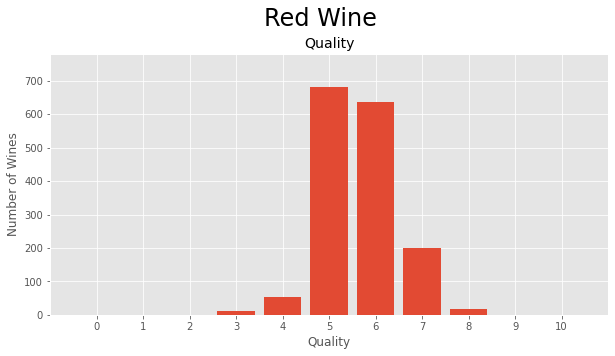

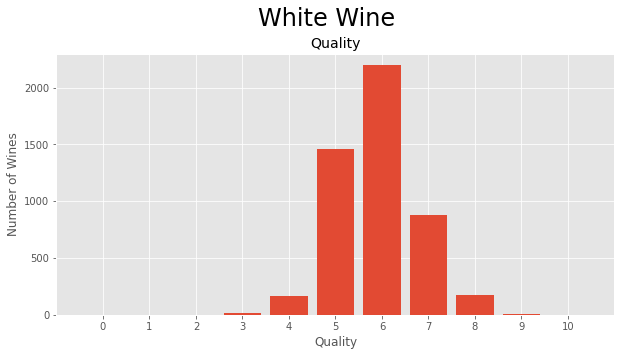

In [13]:
#quality distribution 
print_histograms(data_wine_red[['quality']].to_numpy(), title='Red Wine', subtitles='Quality')
print_histograms(data_wine_white[['quality']].to_numpy(), title='White Wine', subtitles='Quality')

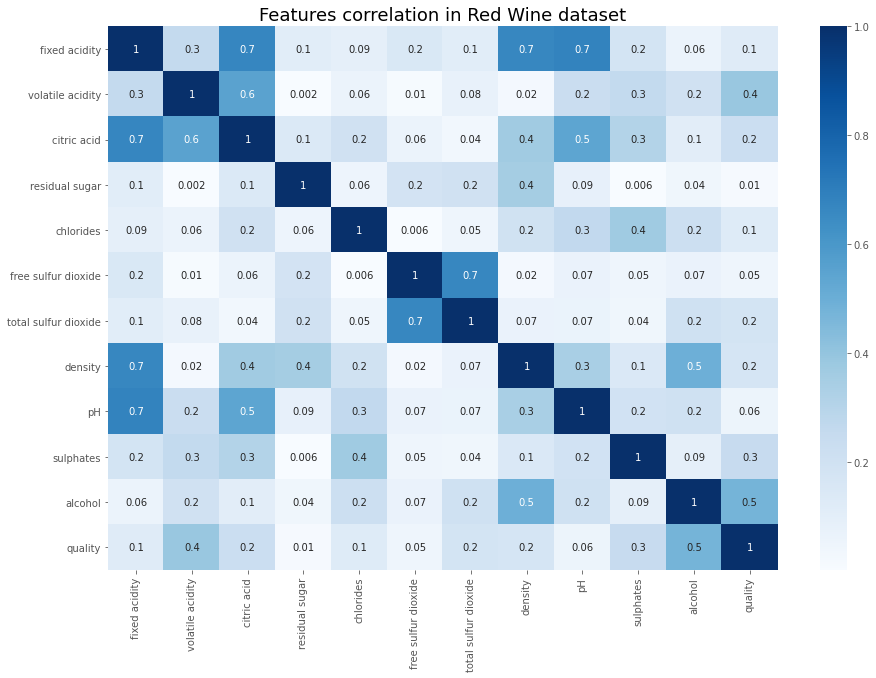

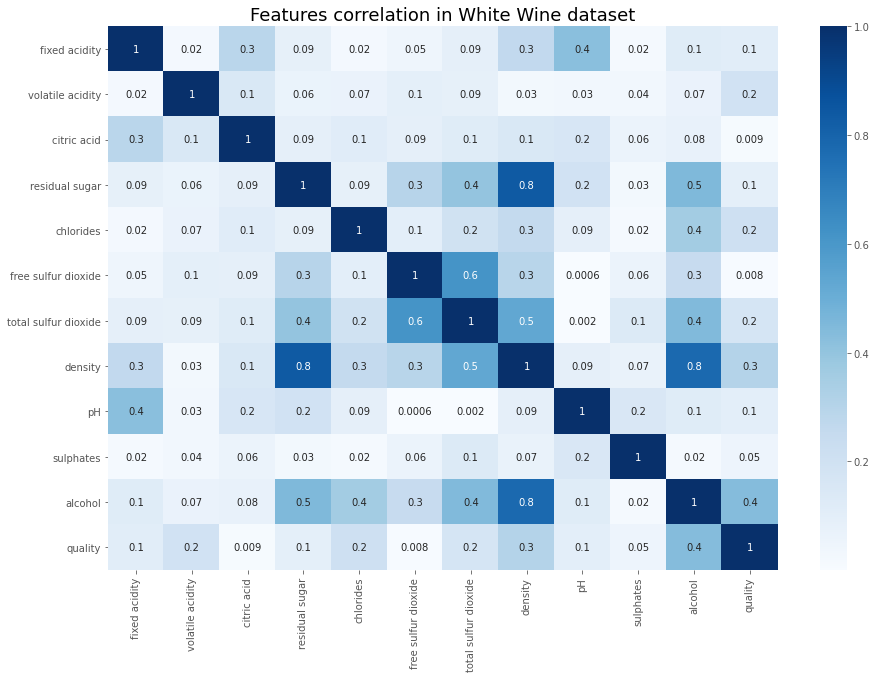

In [14]:
# Features correlation
print_correlation_matrix(data_wine_red.corr().abs(), 'Features correlation in Red Wine dataset')
print_correlation_matrix(data_wine_white.corr().abs(), 'Features correlation in White Wine dataset')

In [15]:
# Drop low correlated features to target ('quality')
threshold = 0.07
to_drop_red_wine = data_wine_red.corr().abs()['quality'] < threshold
to_drop_white_wine = data_wine_white.corr().abs()['quality'] < threshold
to_drop_red_wine = list((to_drop_red_wine[to_drop_red_wine]).index.values)
to_drop_white_wine = list((to_drop_white_wine[to_drop_white_wine]).index.values)
print("Candidate features to be dropped in Red Wine dataset: ", to_drop_red_wine)
print("Candidate features to be dropped in White Wine dataset: ", to_drop_white_wine)

Candidate features to be dropped in Red Wine dataset:  ['residual sugar', 'free sulfur dioxide', 'pH']
Candidate features to be dropped in White Wine dataset:  ['citric acid', 'free sulfur dioxide', 'sulphates']


In [16]:
data_wine_red = data_wine_red.drop(columns=to_drop_red_wine)
data_wine_white = data_wine_white.drop(columns=to_drop_white_wine)
print("Number of features in Red Wine dataset: ", len(data_wine_red.columns))
print("Number of features in White Wine dataset: ", len(data_wine_white.columns))

Number of features in Red Wine dataset:  9
Number of features in White Wine dataset:  9


## Data preprocessing and statistics

### Output conversion

In [17]:
# Recreate datasets
new_data_wine_red = data_wine_red.copy()
new_data_wine_white = data_wine_white.copy()

# 'quality' becomes a binary label: 0 = fail; 1 = pass
new_data_wine_red['quality'] = np.where(new_data_wine_red['quality'] > 5, 1, 0)
new_data_wine_white['quality'] = np.where(new_data_wine_white['quality'] > 5, 1, 0)

In [18]:
new_data_wine_red.head(3)

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,0
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,0
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,0


In [19]:
new_data_wine_white.head(3)

,fixed acidity,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,pH,alcohol,quality
0,7.0,0.27,20.7,0.045,170.0,1.0010,3.00,8.8,1
1,6.3,0.30,1.6,0.049,132.0,0.9940,3.30,9.5,1
2,8.1,0.28,6.9,0.050,97.0,0.9951,3.26,10.1,1


#### Red Wine dataset statistics

Good:  53.47 %
Bad:  46.53 %
Counter({1: 855, 0: 744})


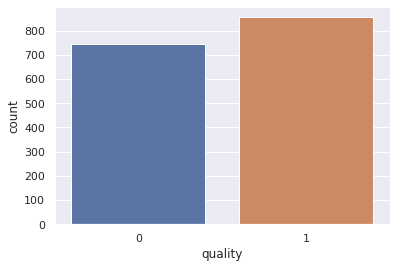

In [20]:
print('Good: ', round(new_data_wine_red['quality'].value_counts()[1]/len(new_data_wine_red)*100, 2),'%')
print('Bad: ', round(new_data_wine_red['quality'].value_counts()[0]/len(new_data_wine_red) * 100, 2), '%')

counter = Counter(new_data_wine_red['quality'].values)
print(counter)

sns.set(style="darkgrid")
sns.countplot(x="quality", data=new_data_wine_red)

#### White Wine dataset statistics

Good:  66.52 %
Bad:  33.48 %
Counter({1: 3258, 0: 1640})


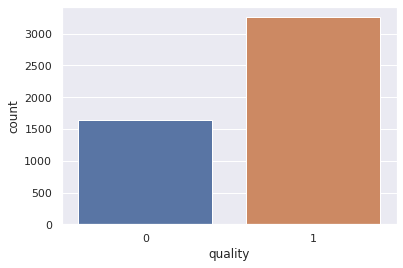

In [21]:
print('Good: ', round(new_data_wine_white['quality'].value_counts()[1]/len(new_data_wine_white)*100, 2),'%')
print('Bad: ', round(new_data_wine_white['quality'].value_counts()[0]/len(new_data_wine_white) * 100, 2), '%')

counter = Counter(new_data_wine_white['quality'].values)
print(counter)

sns.set(style="darkgrid")
sns.countplot(x="quality", data=new_data_wine_white)

### Train and Test set creation

In [22]:
# Create X and y
X_red_wine = new_data_wine_red[new_data_wine_red.columns.difference(['quality'])]
y_red_wine = new_data_wine_red['quality']

X_white_wine = new_data_wine_white[new_data_wine_white.columns.difference(['quality'])]
y_white_wine = new_data_wine_white['quality']

In [23]:
# Create train and test sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_red_wine, y_red_wine, test_size=0.2, stratify=y_red_wine, random_state=42) # 'stratify=y' allows to create a test split with an equal percentage
# of positive and negative labels

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_white_wine, y_white_wine, test_size=0.2, stratify=y_white_wine, random_state=42)

### Bootstrap and Feature Scaling


In [24]:
est_mean_train_r, est_dev_train_r, sem_train_r, err_std_train_r = estimate_mean_stdev_with_bootstrap(X_train_r, n_bootstraps=100)
est_mean_test_r, est_dev_test_r, sem_test_r, err_std_test_r = estimate_mean_stdev_with_bootstrap(X_test_r, n_bootstraps=100)

est_mean_train_w, est_dev_train_w, sem_train_w, err_std_train_w = estimate_mean_stdev_with_bootstrap(X_train_w, n_bootstraps=100, bootstrap_size=700)
est_mean_test_w, est_dev_test_w, sem_test_w, err_std_test_w = estimate_mean_stdev_with_bootstrap(X_test_w, n_bootstraps=100, bootstrap_size=700)

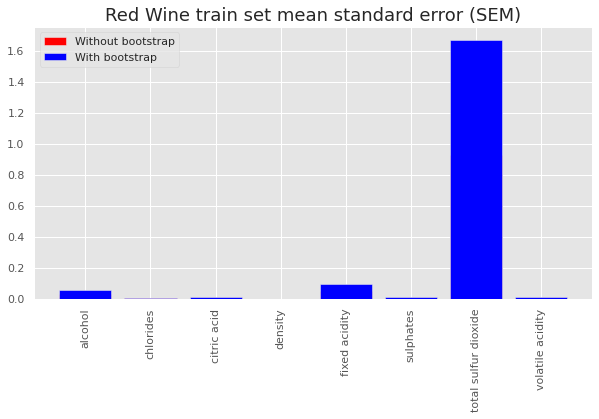

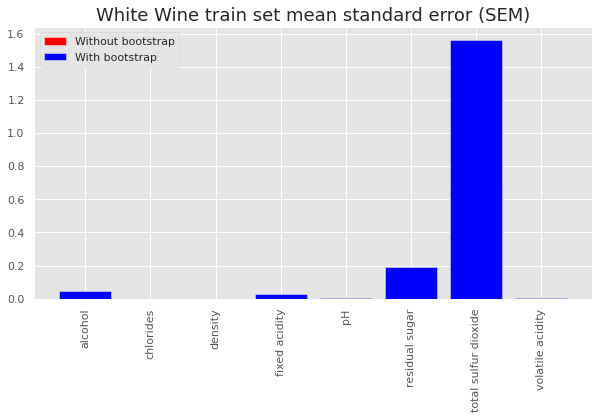

In [61]:
# SEM: measures how far the sample mean of the data is likely to be from the true population mean
plot_df_means(X_train_r.sem(), sem_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set mean standard error (SEM)')
plot_df_means(X_train_w.sem(), sem_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set mean standard error (SEM)')

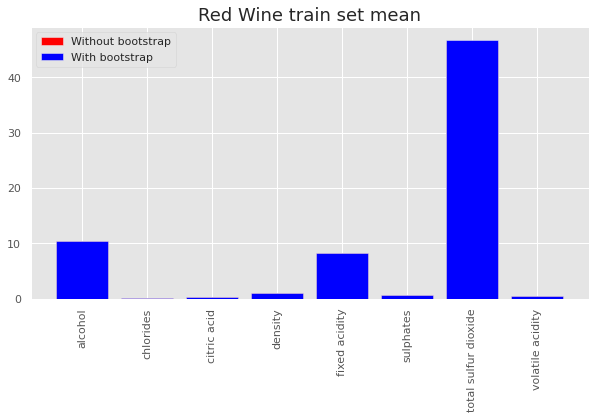

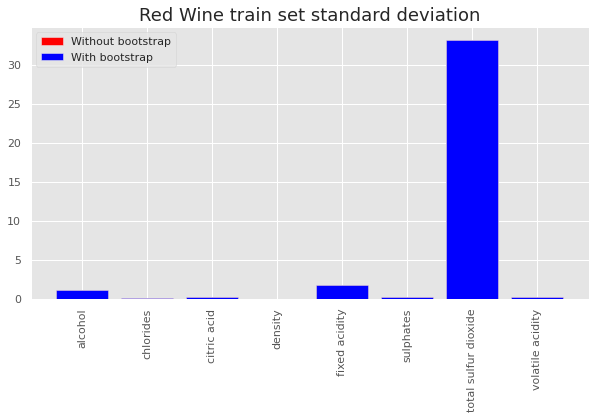

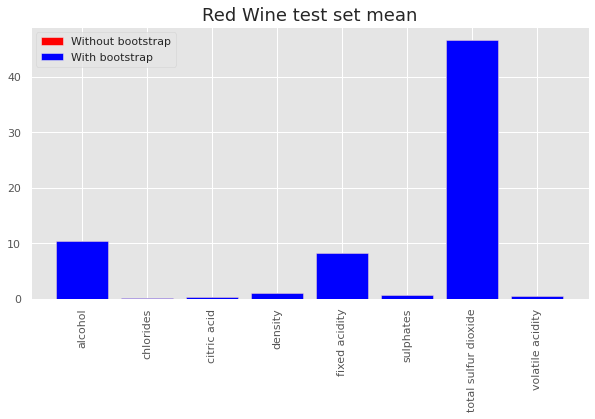

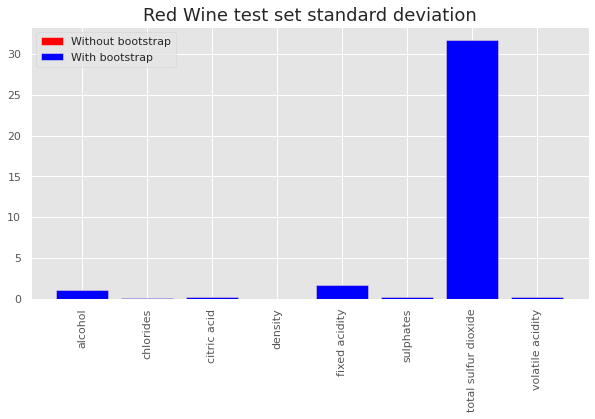

In [62]:
plot_df_means(X_train_r.mean(), est_mean_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set mean')
plot_df_means(X_train_r.std(), est_dev_train_r, 'Without bootstrap','With bootstrap', 'Red Wine train set standard deviation')
plot_df_means(X_test_r.mean(), est_mean_test_r, 'Without bootstrap','With bootstrap', 'Red Wine test set mean')
plot_df_means(X_test_r.std(), est_dev_test_r, 'Without bootstrap','With bootstrap', 'Red Wine test set standard deviation')

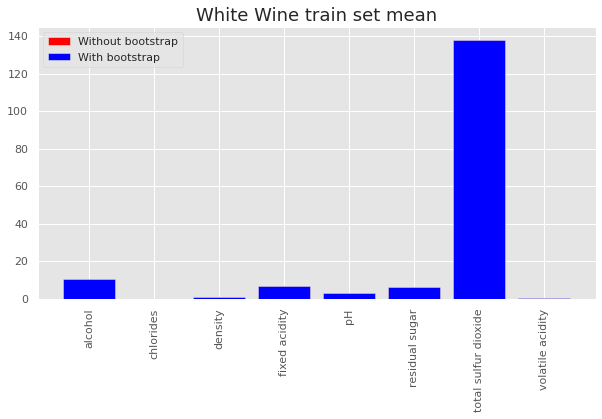

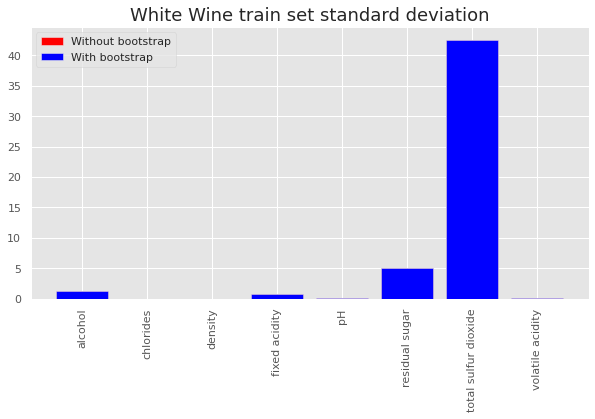

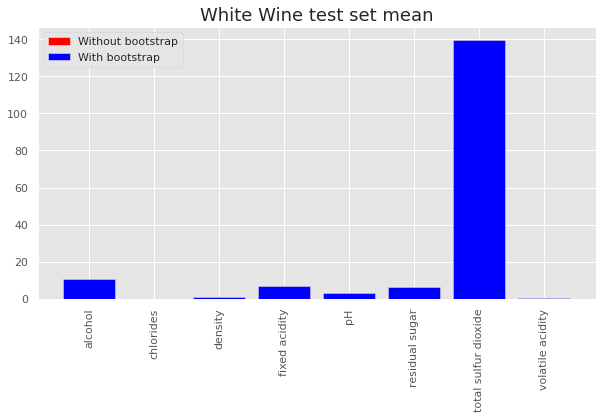

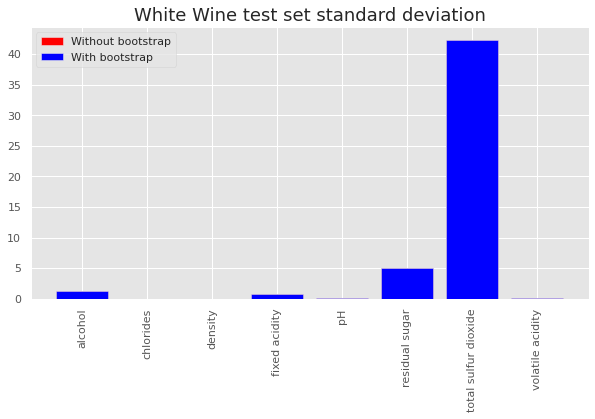

In [64]:
plot_df_means(X_train_w.mean(), est_mean_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set mean')
plot_df_means(X_train_w.std(), est_dev_train_w, 'Without bootstrap','With bootstrap', 'White Wine train set standard deviation')
plot_df_means(X_test_w.mean(), est_mean_test_w, 'Without bootstrap','With bootstrap', 'White Wine test set mean')
plot_df_means(X_test_w.std(), est_dev_test_w, 'Without bootstrap','With bootstrap', 'White Wine test set standard deviation')

In [27]:
X_train_r_std = (X_train_r - est_mean_train_r) / est_dev_train_r
X_test_r_std = (X_test_r - est_mean_test_r) / est_dev_test_r
X_train_w_std = (X_train_w - est_mean_train_w) / est_dev_train_w
X_test_w_std = (X_test_w - est_mean_test_w) / est_dev_test_w



### Principal Component Analysis (PCA)

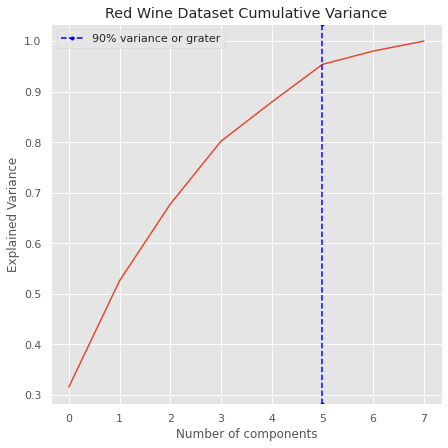

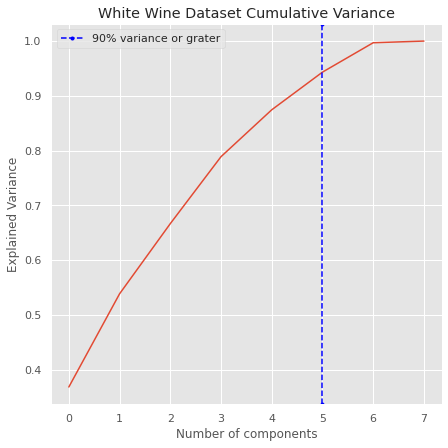

In [28]:
pca_r = PCA()
pca_w = PCA()

X_train_r_pca = pca_r.fit_transform(X_train_r_std)
X_test_r_pca = pca_r.transform(X_test_r_std)

X_train_w_pca = pca_w.fit_transform(X_train_w_std)
X_test_w_pca = pca_w.transform(X_test_w_std)

n_PC_90th_r = plot_explained_variance(pca_r.explained_variance_ratio_, 'Red Wine Dataset Cumulative Variance')
n_PC_90th_w = plot_explained_variance(pca_w.explained_variance_ratio_, 'White Wine Dataset Cumulative Variance')

In [29]:
n_PC_90th_r = int(n_PC_90th_r)
n_PC_90th_w = int(n_PC_90th_w)

X_train_r_reduced = pd.DataFrame(X_train_r_pca[:,:n_PC_90th_r], columns=[f'PC{i}' for i in range(n_PC_90th_r)])
X_train_w_reduced = pd.DataFrame(X_train_w_pca[:,:n_PC_90th_w], columns=[f'PC{i}' for i in range(n_PC_90th_w)])

X_test_r_reduced = pd.DataFrame(X_test_r_pca[:,:n_PC_90th_r], columns=[f'PC{i}' for i in range(n_PC_90th_r)])
X_test_w_reduced = pd.DataFrame(X_test_w_pca[:,:n_PC_90th_w], columns=[f'PC{i}' for i in range(n_PC_90th_w)])

In [30]:
X_train_r_reduced.head(3)

,PC0,PC1,PC2,PC3,PC4
0,-0.190437,-0.540455,-0.071329,-0.340417,-0.442852
1,-0.805809,-0.593218,-0.045430,-0.199388,-0.478365
2,0.539327,0.298992,-0.615394,-0.677575,0.171269


In [31]:
X_train_w_reduced.head(3)

,PC0,PC1,PC2,PC3,PC4
0,-0.048429,-0.534021,-0.477544,-1.312896,-0.324867
1,2.462425,1.100134,-0.856740,-0.369568,-0.173108
2,-1.293747,-0.870020,-0.849658,0.415198,0.582717


### Dataset Oversampling: SMOTE Algorithm (Synthetic Minority Oversampling Technique)
Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [32]:
sampler = SMOTE(random_state=0)

print("###### White Wine dataset ######")
print(Counter(y_train_w))
X_smote_w, y_smote_w = sampler.fit_resample(X_train_w_reduced, y_train_w)
print(Counter(y_smote_w))

###### White Wine dataset ######
Counter({1: 2606, 0: 1312})
Counter({1: 2606, 0: 2606})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Classification

Proposed algorithms:
1. Logistic Regression
2. K-NN
3. SVM
4. Decision Tree
5. Random Forest

The classification algorithms will be trained on both oversampled and not oversampled sets and the obtained results will be compared.

In [33]:
def classification(X_train, y_train, X_test, y_test, clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

In [34]:
def print_classification_report(X_train, y_train, X_test, y_test, clf):
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

### Logistic Regression

#### PCA-reduced dataset

######### Red Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.8s finished


{'C': 0.1}
accuracy Red Wine:
0.725
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       149
           1       0.75      0.72      0.74       171

    accuracy                           0.73       320
   macro avg       0.72      0.73      0.72       320
weighted avg       0.73      0.72      0.73       320



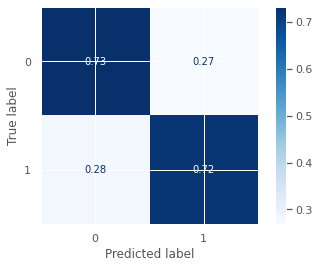

In [35]:
# Parameters Tuning
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
LR_acc= np.zeros((1,3))

print("######### Red Wine dataset #########")
clf_r = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_r = GridSearchCV(clf_r, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_r.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)

LR_acc[0,0] = acc

print(clf_r.best_params_)
print("accuracy Red Wine:")
print(acc)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_r)

######### White Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished


{'C': 1}
accuracy White Wine:
0.7040816326530612
              precision    recall  f1-score   support

           0       0.62      0.30      0.41       328
           1       0.72      0.91      0.80       652

    accuracy                           0.70       980
   macro avg       0.67      0.60      0.60       980
weighted avg       0.69      0.70      0.67       980



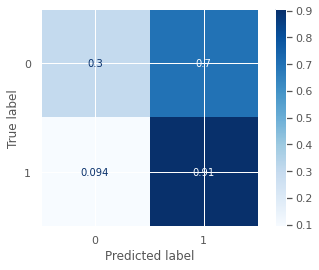

In [36]:
print("######### White Wine dataset #########")
clf_w = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_train_w_reduced, y_train_w).score(X_test_w_reduced, y_test_w)

LR_acc[0,1] = acc
print(clf_w.best_params_)
print("accuracy White Wine:")
print(acc)
print_classification_report(X_train_w_reduced, y_train_w, X_test_w_reduced, y_test_w, clf_w)

#### PCA-reduced dataset and oversampled train set 

######### White Wine dataset #########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.3s finished


{'C': 0.1}
accuracy White Wine smote:
0.7040816326530612
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       328
           1       0.82      0.71      0.76       652

    accuracy                           0.70       980
   macro avg       0.68      0.70      0.69       980
weighted avg       0.73      0.70      0.71       980



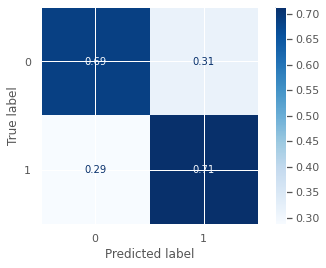

In [37]:
print("######### White Wine dataset #########")
clf_w = LogisticRegression(random_state=0, max_iter=1000, penalty='l2')
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_smote_w, y_smote_w).score(X_test_w_reduced, y_test_w)

LR_acc[0,2] = acc
print(clf_w.best_params_)
print("accuracy White Wine smote:")
print(acc)
print_classification_report(X_smote_w, y_smote_w, X_test_w_reduced, y_test_w, clf_w)

In [38]:
LR_scores = pd.DataFrame(np.round(LR_acc, decimals = 2), columns=['Red Wine', 'White Wine','White wine smote'], index=['Logistic Regression'])
LR_scores 

,Red Wine,White Wine,White wine smote
Logistic Regression,0.72,0.7,0.7


### K-Nearest Neighbors

#### PCA-reduced dataset

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    2.1s finished


{'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
accuracy Red Wine: 
0.78125
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       149
           1       0.79      0.81      0.80       171

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320



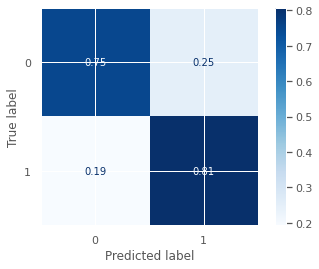

In [39]:
params_grid = {'n_neighbors': np.arange(1,22,2).tolist(), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
KNN_acc = np.zeros((1,3))

clf_r = KNeighborsClassifier()
clf_r = GridSearchCV(clf_r, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_r.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)
KNN_acc[0,0] = acc
print(clf_r.best_params_)
print('accuracy Red Wine: ')
print(acc)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_r)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    6.0s finished


{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'distance'}
accuracy White Wine: 
0.8010204081632653
              precision    recall  f1-score   support

           0       0.74      0.62      0.68       328
           1       0.82      0.89      0.86       652

    accuracy                           0.80       980
   macro avg       0.78      0.76      0.77       980
weighted avg       0.80      0.80      0.80       980



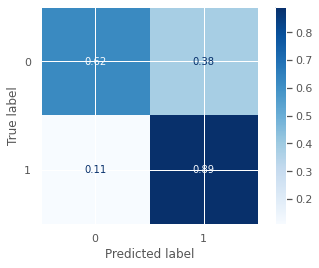

In [40]:
clf_w = KNeighborsClassifier()
clf_w = GridSearchCV(clf_w, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_train_w_reduced, y_train_w).score(X_test_w_reduced, y_test_w)
KNN_acc[0,1] = acc

print(clf_w.best_params_)
print('accuracy White Wine: ')
print(acc)
print_classification_report(X_train_w_reduced, y_train_w, X_test_w_reduced, y_test_w, clf_w)

#### PCA-reduced dataset and oversampled train set

In [41]:
params_grid = {'n_neighbors': np.arange(1,22,2).tolist(), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    7.0s finished


{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
accuracy White Wine smote: 
0.7908163265306123
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       328
           1       0.84      0.85      0.84       652

    accuracy                           0.79       980
   macro avg       0.77      0.76      0.76       980
weighted avg       0.79      0.79      0.79       980



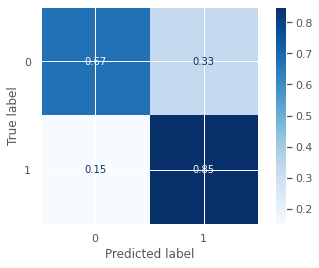

In [42]:
clf_w = KNeighborsClassifier()
clf_w = GridSearchCV(clf_w, param_grid = params_grid, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_smote_w, y_smote_w).score(X_test_w_reduced, y_test_w)
KNN_acc[0,2] = acc
print(clf_w.best_params_)

print('accuracy White Wine smote: ')
print(acc)
print_classification_report(X_smote_w, y_smote_w, X_test_w_reduced, y_test_w, clf_w)

In [43]:
KNN_scores = pd.DataFrame(np.round(KNN_acc, decimals = 2), columns=['Red Wine', 'White Wine','White wine smote'], index=['KNN'])
KNN_scores 

,Red Wine,White Wine,White wine smote
KNN,0.78,0.8,0.79


### Support Vector Machines

#### PCA-reduced dataset

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   16.1s finished


######### Linear kernel param (Red Wine) #########
{'C': 0.01}
accuracy: 
0.734375
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       149
           1       0.78      0.70      0.74       171

    accuracy                           0.73       320
   macro avg       0.74      0.74      0.73       320
weighted avg       0.74      0.73      0.73       320

######### RBF kernel param (Red Wine) #########
{'C': 1000, 'gamma': 0.001}
accuracy: 
0.74375
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       149
           1       0.78      0.73      0.75       171

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.75      0.74      0.74       320



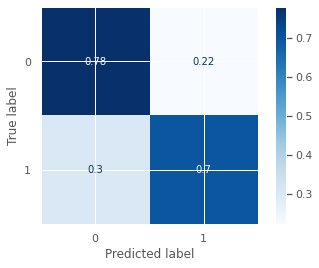

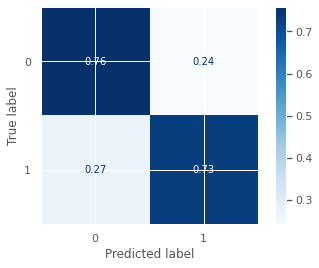

In [44]:
params_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]} 
params_grid_rbf    = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [10**(-7), 10**(-5), 10**(-3), 10**(-1), 0.5, 1, 10, 100]}

SVM_acc_linear = np.zeros((1,3))
SVM_acc_rbf = np.zeros((1,3))

clf_r_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_r_linear = GridSearchCV(clf_r_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_r_linear.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)

SVM_acc_linear[0,0] = acc_linear

clf_r_rbf = SVC(kernel = 'rbf')
clf_r_rbf = GridSearchCV(clf_r_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_r_rbf.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)

SVM_acc_rbf[0,0] = acc_rbf

print("######### Linear kernel param (Red Wine) #########")
print(clf_r_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_r_linear)



print("######### RBF kernel param (Red Wine) #########")
print(clf_r_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_r_rbf)

          PC0       PC1       PC2       PC3       PC4
0    0.027327 -0.382613 -0.313297  0.087523  0.185724
1   -0.692586  0.221684 -0.089750 -0.568029  0.331158
2   -1.745142 -1.917072 -1.740377 -1.315188 -0.086774
3    0.169567 -1.087845 -0.683193 -0.821711 -0.352271
4   -1.846035  0.794993  1.147708 -0.903144  2.045369
..        ...       ...       ...       ...       ...
315 -1.111272  1.323043  0.876892 -0.554456  0.263969
316  0.446415 -1.438693 -0.232351  2.693930  0.349360
317 -1.147401 -1.434038 -0.508226 -0.794791 -0.309425
318  0.374519 -0.927080 -1.050810 -0.440525 -0.001033
319 -0.002588 -1.449346  0.347542  0.741294  0.426502

[320 rows x 5 columns]
n_features:  5
          PC0       PC1       PC2       PC3       PC4
0    0.027327 -0.382613 -0.313297  0.087523  0.185724
1   -0.692586  0.221684 -0.089750 -0.568029  0.331158
2   -1.745142 -1.917072 -1.740377 -1.315188 -0.086774
3    0.169567 -1.087845 -0.683193 -0.821711 -0.352271
4   -1.846035  0.794993  1.147708 -0.903144

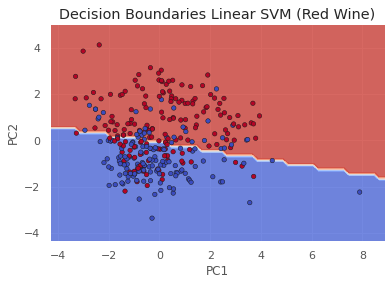

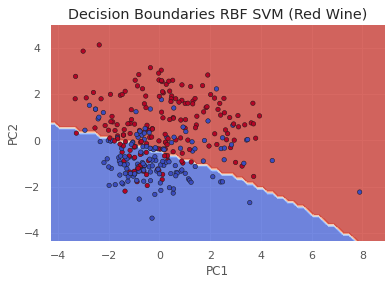

In [45]:
decision_boundaries(X_test_r_reduced, y_test_r, 'Decision Boundaries Linear SVM (Red Wine)', clf_r_linear)
decision_boundaries(X_test_r_reduced, y_test_r, 'Decision Boundaries RBF SVM (Red Wine)', clf_r_rbf)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.3min finished


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  2.8min finished


######### Linear kernel param (White Wine) #########
{'C': 10}
accuracy: 
0.689795918367347
              precision    recall  f1-score   support

           0       0.67      0.15      0.24       328
           1       0.69      0.96      0.81       652

    accuracy                           0.69       980
   macro avg       0.68      0.55      0.52       980
weighted avg       0.68      0.69      0.62       980

######### RBF kernel param (White Wine) #########
{'C': 1, 'gamma': 1}
accuracy: 
0.7591836734693878
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       328
           1       0.79      0.87      0.83       652

    accuracy                           0.76       980
   macro avg       0.73      0.70      0.71       980
weighted avg       0.75      0.76      0.75       980



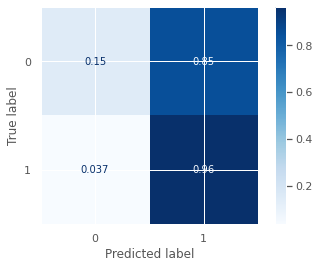

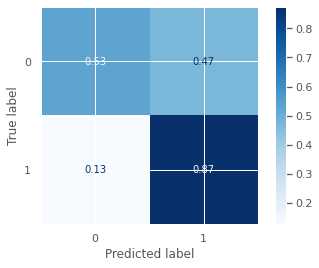

In [46]:
clf_w_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_w_linear = GridSearchCV(clf_w_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_w_linear.fit(X_train_w_reduced, y_train_w).score(X_test_w_reduced, y_test_w)


SVM_acc_linear[0,1] = acc_linear

clf_w_rbf = SVC(kernel = 'rbf')
clf_w_rbf = GridSearchCV(clf_w_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_w_rbf.fit(X_train_w_reduced, y_train_w).score(X_test_w_reduced, y_test_w)



SVM_acc_rbf[0,1] = acc_rbf

print("######### Linear kernel param (White Wine) #########")
print(clf_w_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_train_w_reduced, y_train_w, X_test_w_reduced, y_test_w, clf_w_linear)


print("######### RBF kernel param (White Wine) #########")
print(clf_w_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_train_w_reduced, y_train_w, X_test_w_reduced, y_test_w, clf_w_rbf)

          PC0       PC1       PC2       PC3       PC4
0   -0.600346 -1.852627  0.828450 -0.654139  1.072238
1   -0.424802  0.228893  0.414883  1.226389 -0.434524
2    1.364518 -1.505821 -0.964854 -0.659003 -0.074178
3   -1.833616 -2.306109 -1.279875  0.153970  0.263581
4    2.128350  0.075462  0.631181 -1.392597 -0.154455
..        ...       ...       ...       ...       ...
975  2.366068 -0.911753  0.135910 -0.837284 -1.240541
976 -0.787682  0.693661 -0.746570  0.736523  0.207137
977  2.606058 -1.124173 -1.142076 -0.495980 -1.146250
978  0.328081 -1.632527 -1.798959  1.009829  1.009867
979 -2.343529  0.080947  1.437003 -1.058997 -0.109361

[980 rows x 5 columns]
n_features:  5
          PC0       PC1       PC2       PC3       PC4
0   -0.600346 -1.852627  0.828450 -0.654139  1.072238
1   -0.424802  0.228893  0.414883  1.226389 -0.434524
2    1.364518 -1.505821 -0.964854 -0.659003 -0.074178
3   -1.833616 -2.306109 -1.279875  0.153970  0.263581
4    2.128350  0.075462  0.631181 -1.392597

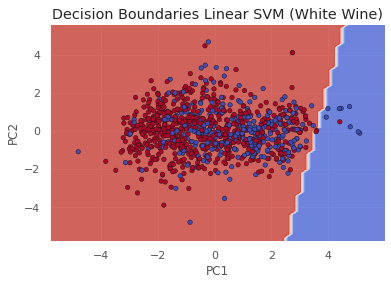

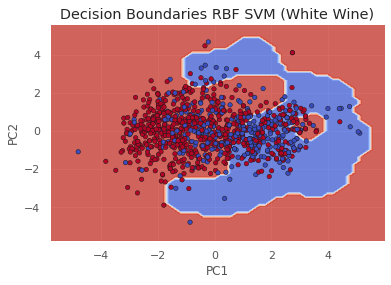

In [47]:
decision_boundaries(X_test_w_reduced, y_test_w, 'Decision Boundaries Linear SVM (White Wine)', clf_w_linear)
decision_boundaries(X_test_w_reduced, y_test_w, 'Decision Boundaries RBF SVM (White Wine)', clf_w_rbf)

#### PCA-reduced dataset and oversampled train set

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.6min finished


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  5.0min finished


######### Linear kernel param (White Wine smote)#########
{'C': 1000}
accuracy: 
0.6938775510204082
              precision    recall  f1-score   support

           0       0.53      0.72      0.61       328
           1       0.83      0.68      0.75       652

    accuracy                           0.69       980
   macro avg       0.68      0.70      0.68       980
weighted avg       0.73      0.69      0.70       980

######### RBF kernel param (White Wine smote)#########
{'C': 10, 'gamma': 10}
accuracy: 
0.7755102040816326
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       328
           1       0.78      0.93      0.85       652

    accuracy                           0.78       980
   macro avg       0.78      0.70      0.71       980
weighted avg       0.78      0.78      0.76       980



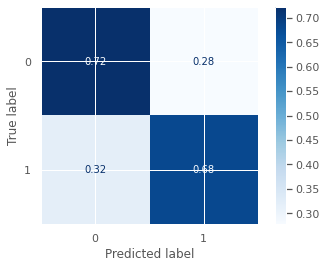

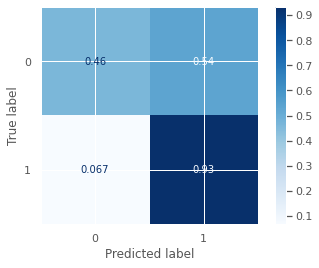

In [48]:
clf_w_linear = SVC(kernel = 'linear', gamma = 'auto')
clf_w_linear = GridSearchCV(clf_w_linear, param_grid = params_grid_linear, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_linear = clf_w_linear.fit(X_smote_w, y_smote_w).score(X_test_w_reduced, y_test_w)

SVM_acc_linear[0,2] = acc_linear

clf_w_rbf = SVC(kernel = 'rbf')
clf_w_rbf = GridSearchCV(clf_w_rbf, param_grid = params_grid_rbf, scoring = 'accuracy', verbose=1, n_jobs=-1)
acc_rbf = clf_w_rbf.fit(X_smote_w, y_smote_w).score(X_test_w_reduced, y_test_w)

SVM_acc_rbf[0,2] = acc_rbf 

print("######### Linear kernel param (White Wine smote)#########")
print(clf_w_linear.best_params_)
print('accuracy: ')
print(acc_linear)
print_classification_report(X_smote_w, y_smote_w, X_test_w_reduced, y_test_w, clf_w_linear)

print("######### RBF kernel param (White Wine smote)#########")
print(clf_w_rbf.best_params_)
print('accuracy: ')
print(acc_rbf)
print_classification_report(X_smote_w, y_smote_w, X_test_w_reduced, y_test_w, clf_w_rbf)

          PC0       PC1       PC2       PC3       PC4
0   -0.600346 -1.852627  0.828450 -0.654139  1.072238
1   -0.424802  0.228893  0.414883  1.226389 -0.434524
2    1.364518 -1.505821 -0.964854 -0.659003 -0.074178
3   -1.833616 -2.306109 -1.279875  0.153970  0.263581
4    2.128350  0.075462  0.631181 -1.392597 -0.154455
..        ...       ...       ...       ...       ...
975  2.366068 -0.911753  0.135910 -0.837284 -1.240541
976 -0.787682  0.693661 -0.746570  0.736523  0.207137
977  2.606058 -1.124173 -1.142076 -0.495980 -1.146250
978  0.328081 -1.632527 -1.798959  1.009829  1.009867
979 -2.343529  0.080947  1.437003 -1.058997 -0.109361

[980 rows x 5 columns]
n_features:  5
          PC0       PC1       PC2       PC3       PC4
0   -0.600346 -1.852627  0.828450 -0.654139  1.072238
1   -0.424802  0.228893  0.414883  1.226389 -0.434524
2    1.364518 -1.505821 -0.964854 -0.659003 -0.074178
3   -1.833616 -2.306109 -1.279875  0.153970  0.263581
4    2.128350  0.075462  0.631181 -1.392597

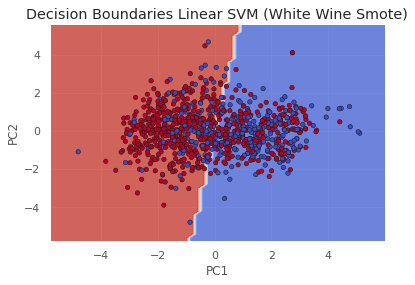

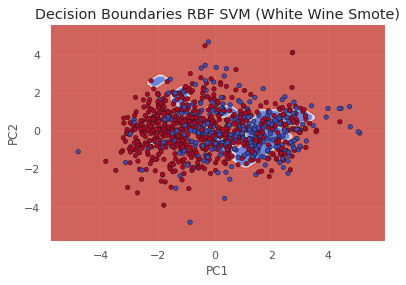

In [49]:
decision_boundaries(X_test_w_reduced, y_test_w, 'Decision Boundaries Linear SVM (White Wine Smote)', clf_w_linear)
decision_boundaries(X_test_w_reduced, y_test_w, 'Decision Boundaries RBF SVM (White Wine Smote)', clf_w_rbf)

In [50]:
SVM_scores_linear = pd.DataFrame(np.round(SVM_acc_linear, 2), columns=['Red Wine', 'White Wine','White wine smote'], index=['SVM linear'])
SVM_scores_rbf = pd.DataFrame(np.round(SVM_acc_rbf, 2), columns=['Red Wine', 'White Wine','White wine smote'], index=['SVM rbf'])
SVM_scores_linear

,Red Wine,White Wine,White wine smote
SVM linear,0.73,0.69,0.69


### Decision Tree

#### PCA-reduced dataset

######### Red Wine dataset #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   28.0s finished


{'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.6625
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       149
           1       0.68      0.71      0.69       171

    accuracy                           0.66       320
   macro avg       0.66      0.66      0.66       320
weighted avg       0.66      0.66      0.66       320



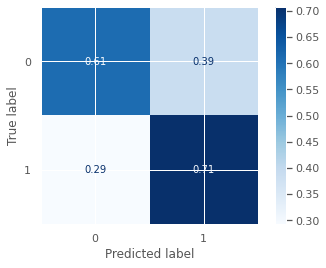

In [51]:
# Parameters Tuning
params_grid = {'criterion': ['gini','entropy'], 'max_depth': np.arange(1,22,5).tolist(),'min_samples_split': np.arange(1,11).tolist(), 
               'min_samples_leaf': np.arange(1,11).tolist()}
DT_acc = np.zeros((1,3))
print("######### Red Wine dataset #########")
clf_r = DecisionTreeClassifier()
clf_r = GridSearchCV(clf_r, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_r.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)

DT_acc[0,0] = acc
print(clf_r.best_params_)
print(acc)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_r)

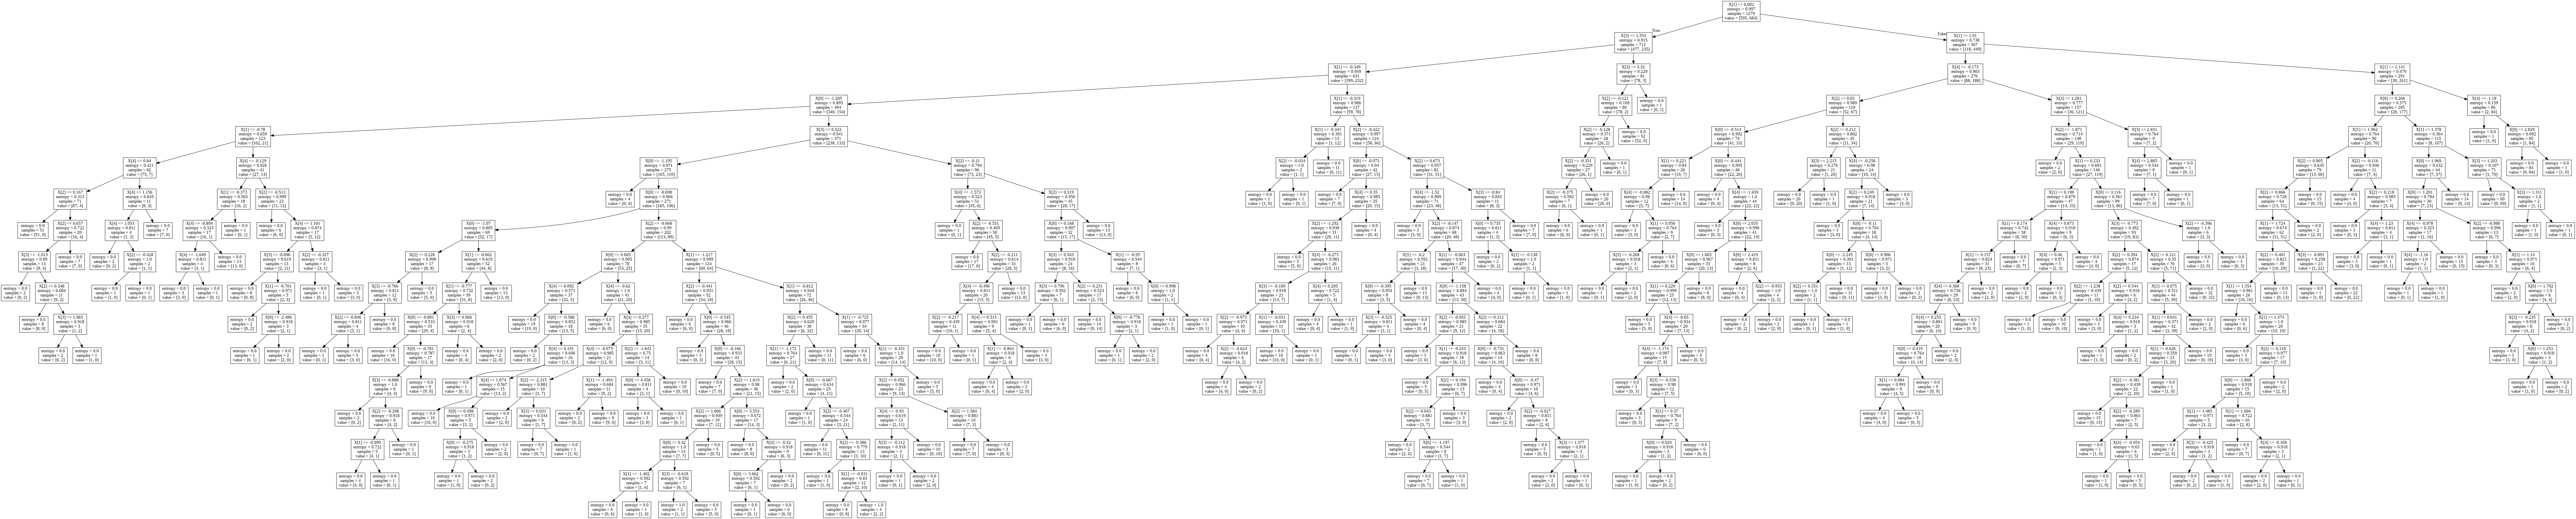

In [52]:
# Print example of DT
dot_data = StringIO() 
tree.export_graphviz(clf_r.best_estimator_, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

######### White Wine dataset #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 4186 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.2min finished


{'criterion': 'entropy', 'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.7316326530612245
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       328
           1       0.80      0.80      0.80       652

    accuracy                           0.73       980
   macro avg       0.70      0.70      0.70       980
weighted avg       0.73      0.73      0.73       980



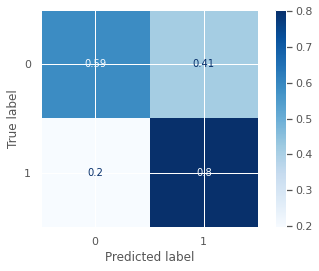

In [53]:
print("######### White Wine dataset #########")
clf_w = DecisionTreeClassifier()
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_train_w_reduced, y_train_w).score(X_test_w_reduced, y_test_w)
DT_acc[0,1] = acc

print(clf_w.best_params_)
print(acc)
print_classification_report(X_train_w_reduced, y_train_w, X_test_w_reduced, y_test_w, clf_w)

#### PCA-reduced dataset and oversampled train set

######### White Wine dataset smote #########
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 4388 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.5min finished


{'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.7061224489795919
              precision    recall  f1-score   support

           0       0.55      0.62      0.59       328
           1       0.80      0.75      0.77       652

    accuracy                           0.71       980
   macro avg       0.68      0.69      0.68       980
weighted avg       0.72      0.71      0.71       980



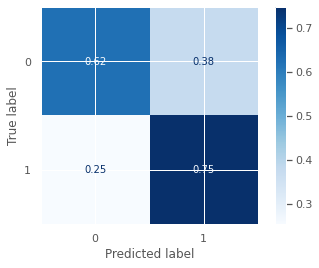

In [54]:
print("######### White Wine dataset smote #########")
clf_w = DecisionTreeClassifier()
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_smote_w, y_smote_w).score(X_test_w_reduced, y_test_w)

DT_acc[0,2] = acc
print(clf_w.best_params_)
print(acc)
print_classification_report(X_smote_w, y_smote_w, X_test_w_reduced, y_test_w, clf_w)

In [55]:
DT_scores = pd.DataFrame(np.round(DT_acc, 2), columns=['Red Wine', 'White Wine','White wine smote'], index=['Decision Tree'])
DT_scores

,Red Wine,White Wine,White wine smote
Decision Tree,0.66,0.73,0.71


### Random Forest

#### PCA-reduced dataset

######### Red Wine dataset #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   48.4s finished


{'criterion': 'entropy', 'n_estimators': 301}
0.775
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       149
           1       0.78      0.81      0.79       171

    accuracy                           0.78       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.78      0.77       320



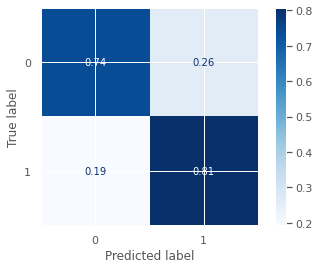

In [56]:
# Parameters Tuning
params_grid = {'n_estimators': np.arange(1,1001,300).tolist(), 'criterion': ['gini','entropy']}
RF_acc = np.zeros((1,3))

print("######### Red Wine dataset #########")
clf_r = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_r = GridSearchCV(clf_r, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_r.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)

RF_acc[0,0] = acc
print(clf_r.best_params_)
print(acc)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_r)

######### White Wine dataset #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   48.1s finished


{'criterion': 'entropy', 'n_estimators': 301}
0.775
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       149
           1       0.78      0.81      0.79       171

    accuracy                           0.78       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.78      0.77       320



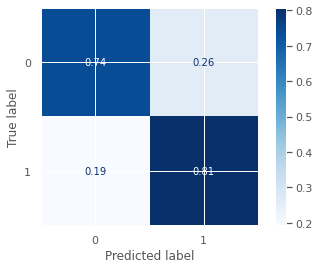

In [57]:
print("######### White Wine dataset #########")
clf_w = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_train_r_reduced, y_train_r).score(X_test_r_reduced, y_test_r)

RF_acc[0,1] = acc
print(clf_w.best_params_)
print(acc)
print_classification_report(X_train_r_reduced, y_train_r, X_test_r_reduced, y_test_r, clf_w)

#### PCA-reduced dataset and oversampled train set

######### White Wine dataset smote #########
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.9min finished


{'criterion': 'entropy', 'n_estimators': 601}
0.7989795918367347
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       328
           1       0.85      0.84      0.85       652

    accuracy                           0.80       980
   macro avg       0.77      0.78      0.78       980
weighted avg       0.80      0.80      0.80       980



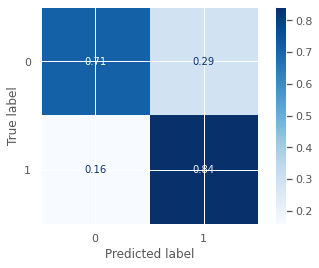

In [58]:
print("######### White Wine dataset smote #########")
clf_w = RandomForestClassifier(max_features='sqrt', random_state=0)
clf_w = GridSearchCV(clf_w, param_grid=params_grid, scoring='accuracy', verbose=1, n_jobs=-1)
acc = clf_w.fit(X_smote_w, y_smote_w).score(X_test_w_reduced, y_test_w)

RF_acc[0,2] = acc
print(clf_w.best_params_)
print(acc)
print_classification_report(X_smote_w, y_smote_w, X_test_w_reduced, y_test_w, clf_w)

In [59]:
RF_scores = pd.DataFrame(np.round(RF_acc, 2), columns=['Red Wine', 'White Wine','White wine smote'], index=['Random Forest'])
RF_scores

,Red Wine,White Wine,White wine smote
Random Forest,0.78,0.78,0.8


## Conclusions

In [60]:
classification_results = LR_scores.append(KNN_scores).append(SVM_scores_linear).append(SVM_scores_rbf).append(DT_scores).append(RF_scores)
classification_results

,Red Wine,White Wine,White wine smote
Logistic Regression,0.72,0.70,0.70
KNN,0.78,0.80,0.79
SVM linear,0.73,0.69,0.69
SVM rbf,0.74,0.76,0.78
Decision Tree,0.66,0.73,0.71
Random Forest,0.78,0.78,0.80
